# Duty Cycle

This script explores duty cycle's exitence in collected data. 
It also fit a model to predict duty cycle's length.

In [1]:
from __future__ import absolute_import, division, print_function

import matplotlib
rc_fonts = {
    "font.weight": 800,
    "font.family": "serif",
    "font.serif": ["Times"], # use latex's default
    "font.sans-serif": ["DejaVu Sans"],
    "text.usetex": True,
}
matplotlib.rcParams.update(rc_fonts)
import matplotlib.pyplot as plt
import numpy as np
import sqlalchemy as sql

from rmexp import dbutils, config, dataset_analysis as analysis
from rmexp.schema import models
from logzero import logger
import operator
import itertools

## Lego Duty Cyle

### Lego Traces to Use

In [2]:
# the paper used 1,3,4,6. However, lego-tr6 seems to
# be giving out wrong number of states using the most recent fsm
# lego_trace_ids = [1, 3, 4, 6]
lego_trace_ids = [1, 3, 4]

In [11]:
import numpy as np
import collections
import lego
from rmexp import dataset_analysis as analysis

# find all the detected stage changes, there should be 7 steps in total
dataset_stage_info = []
for trace_id in lego_trace_ids:
    fsm = lego.fsm.LegoFSM(cnt_to_transition=5)
    ss = analysis.get_ss_df('lego', trace_id)
    inst = analysis.run_fsm_on_ss_for_inst(fsm, ss)
    detected_stages = inst[inst.notnull()].index.values
    print('==================lego-tr{}============='.format(trace_id))
    print('valid? {}. Expected number of states is 7, actual {}'.format(len(detected_stages)==7, len(detected_stages)))
    print(detected_stages)
    dataset_stage_info.append(detected_stages)
    # Insert Ground Truth Transition Frame Index to DB
#    analysis.upload_lego_gt_inst_idx(trace_id, detected_stages, store=True)

==================lego-tr1=============
valid? True. Expected number of states is 7, actual 7
[ 290  512  816 1176 1667 2104 2425]
==================lego-tr3=============
valid? True. Expected number of states is 7, actual 7
[ 320  707 1117 1497 1874 2323 2820]
==================lego-tr4=============
valid? True. Expected number of states is 7, actual 7
[ 259  590 1205 1597 1991 2499 2892]


### Insights into Assembly Step Length

stage length (# s) 
[[ 7.4        10.13333333 12.         16.36666667 14.56666667 10.7       ]
 [12.9        13.66666667 12.66666667 12.56666667 14.96666667 16.56666667]
 [11.03333333 20.5        13.06666667 13.13333333 16.93333333 13.1       ]]
avg stage length by user 
[11.86111111 13.88888889 14.62777778]
avg stage length by stage 
[10.44444444 14.76666667 12.57777778 14.02222222 15.48888889 13.45555556]
avg stage length 13.46, min 7.4, max 20.5


/home/junjuew/work/resource-management/conda-env-rmexp/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


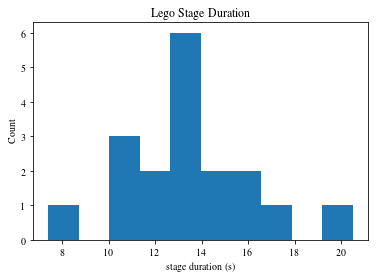

In [22]:
# get dataset stage information
# avg stage length 14.13, min 6.6, max 27.2
dataset_stage_info = np.asarray(dataset_stage_info)
dataset_stage_length = (dataset_stage_info[:, 1:] - dataset_stage_info[:, :-1])/30.0
print("stage length (# s) \n{}".format(dataset_stage_length))
print("avg stage length by user \n{}".format(np.mean(dataset_stage_length, axis=1)))
print("avg stage length by stage \n{}".format(np.mean(dataset_stage_length, axis=0)))
print("avg stage length {:.2f}, min {}, max {}".format(np.mean(dataset_stage_length), 
                                                         np.min(dataset_stage_length), 
                                                         np.max(dataset_stage_length)))
def plot_stage_duration(data):
    data = data.flatten()
    plt.figure()
    plt.hist(data);
    plt.ylabel('Count');
    plt.xlabel('stage duration (s)');
    plt.title('Lego Stage Duration')

plot_stage_duration(dataset_stage_length)

### Fit Assembly Stage Length with a Model

fitted Gaussian Model has mu 15.2152777778 and sigma 4.60213295121


<IPython.core.display.Javascript object>


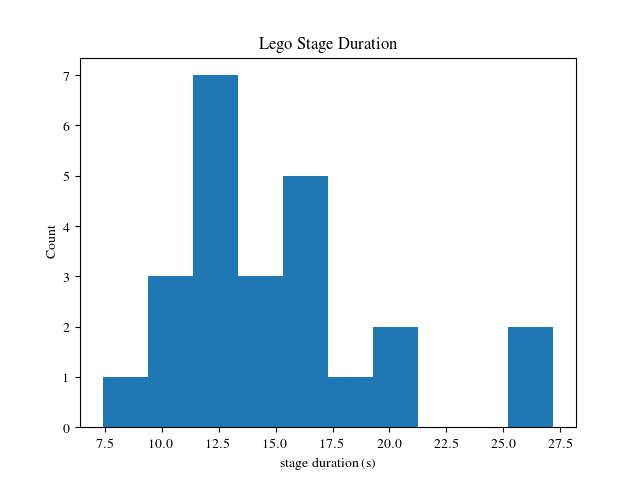

<IPython.core.display.Javascript object>


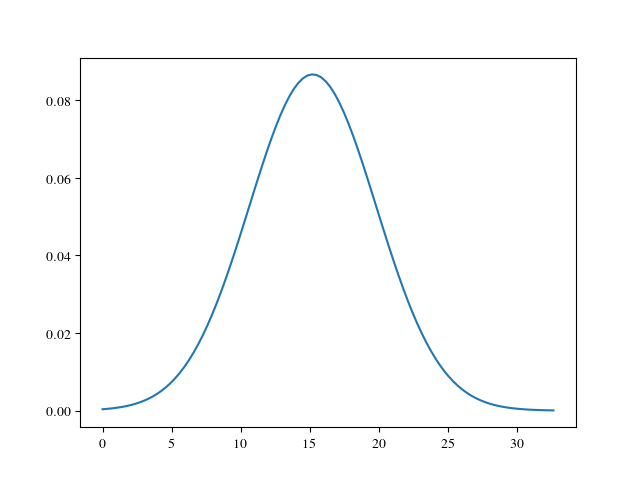

In [142]:
%matplotlib notebook

# fit a gaussian model using MLE for stage duration
# the mean is just sample mean, and sigma is just sample std
from scipy.stats import norm

def fit_gaussian(data):
    data = data.flatten()
    return np.mean(data), np.std(data)

stage_duration_gaussian_model = fit_gaussian(dataset_stage_length)
print('fitted Gaussian Model has mu {} and sigma {}'.format(*stage_duration_gaussian_model))
plot_stage_duration(dataset_stage_length)
plt.figure()
x = np.linspace(0, np.max(dataset_stage_length)*1.2, 100)
plt.plot(x, norm.pdf(x, *stage_duration_gaussian_model));

## Dynamic Sampling Rate

k consecutive frames, S is the sampling period, p is the processing delay for a frame (use average as an estimate), b is the bound:

(k+1) * S + p <= b

1000/S <= max_sampling_frequency

1000/S <= min(maximum processing rate, network transmission rate)

So for lego (370 is the average full processing delay from trace 1 to 5, running on 2 cloudlet cores)

(5 + 1) * S + 370 <= 2700

1000/S <= 30
1000/S <= min(maximum processing rate, network transmission rate)

Then use the CDF of the curve as the dynamic sampling rate ranged from 2.58 Hz to 30 Hz

### Plot Lego Dynamic Sampling Rate

sr_min is 1.78332590281


<IPython.core.display.Javascript object>


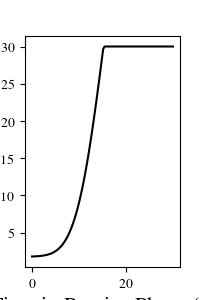

In [154]:
from scipy.stats import norm

proc_delays = {
    'lego': 457 # see the bottom of utility-function notebook. this is the 90th percentile of processing delay
}

# sr_min is 370
proc_delay = proc_delays['lego']
sr_min = 1000.0 / ((2700 - proc_delay) / 4.0)
print('sr_min is {}'.format(sr_min))
sr_max = 30.0
recover_factor = 2
dynamic_sample_rate = lambda x: sr_min + float(sr_max - sr_min) * min(recover_factor * norm.cdf(
    x, *stage_duration_gaussian_model), 1.0)

def plot_lego_sample_rate():
    x=np.linspace(0, 30, 100)
    y = np.vectorize(dynamic_sample_rate, otypes=[np.float])(x)
    plt.figure(figsize=(2,3))
    plt.plot(x, y, 'black')
    plt.xlabel('Time in Passive Phase (s)', fontsize=16)
    plt.ylabel('Sampling Rate (Hz)', fontsize=18)

plot_lego_sample_rate()

### Simulate Dynamic Sampling Rate

Calculate dynamic sampling rate's # of frame not sampled and instruction frame delay.

In [6]:
# show and plot dynamic sampling rate
from rmexp.client import dutycycle
from rmexp import dataset_analysis as analysis
import lego

dy_ss = []
for trace_id in lego_trace_ids:
    fsm = lego.fsm.LegoFSM(cnt_to_transition=5)
    ss = analysis.get_ss_df('lego', trace_id)
    dy_exp_ss, dy_stage_frame_idx = analysis.run_fsm_on_ss_for_samples_with_dynamic_rate(
        fsm, ss, dutycycle.dynamic_sampling_rate['lego'])
    dy_stage_frame_idx = np.asarray(dy_stage_frame_idx)
    gt_inst_idx = analysis.get_gt_inst_idx('lego', trace_id)
    dy_stage_frame_diff = dy_stage_frame_idx - gt_inst_idx

    dy_ss.append(dy_exp_ss)
    print("===================lego-tr{}=============".format(trace_id))
    print("dynamic sampled stage idx: ")
    print(dy_stage_frame_idx)
    print("ground truth stage idx:    ")
    print(gt_inst_idx)
    print('frame delay (in frames): ')
    print(dy_stage_frame_diff)
    print('frame delay average: {}, std: {}'.format(np.mean(dy_stage_frame_diff), np.std(dy_stage_frame_diff)))
    print('# of sampled frames: {}, percentage: {}'.format(len(dy_exp_ss), float(len(dy_exp_ss)) / len(ss)))

===================lego-tr1=============
dynamic sampled stage idx: 
[ 290  545  835 1183 1667 2108 2447]
ground truth stage idx:    
[290, 512, 816, 1176, 1667, 2104, 2425]
frame delay (in frames): 
[ 0 33 19  7  0  4 22]
frame delay average: 12.1428571429, std: 11.7525507435
# of sampled frames: 591, percentage: 0.226784343822
===================lego-tr3=============
dynamic sampled stage idx: 
[ 320  711 1120 1501 1880 2341 2822]
ground truth stage idx:    
[317, 707, 1117, 1497, 1874, 2323, 2820]
frame delay (in frames): 
[ 3  4  3  4  6 18  2]
frame delay average: 5.71428571429, std: 5.14682386704
# of sampled frames: 744, percentage: 0.260230849948
===================lego-tr4=============
dynamic sampled stage idx: 
[ 259  598 1205 1604 2003 2499 2906]
ground truth stage idx:    
[259, 590, 1205, 1597, 1991, 2499, 2892]
frame delay (in frames): 
[ 0  8  0  7 12  0 14]
frame delay average: 5.85714285714, std: 5.51435973303
# of sampled frames: 846, percentage: 0.27193828351


### Plot Dynamic Sampling Rate

<IPython.core.display.Javascript object>


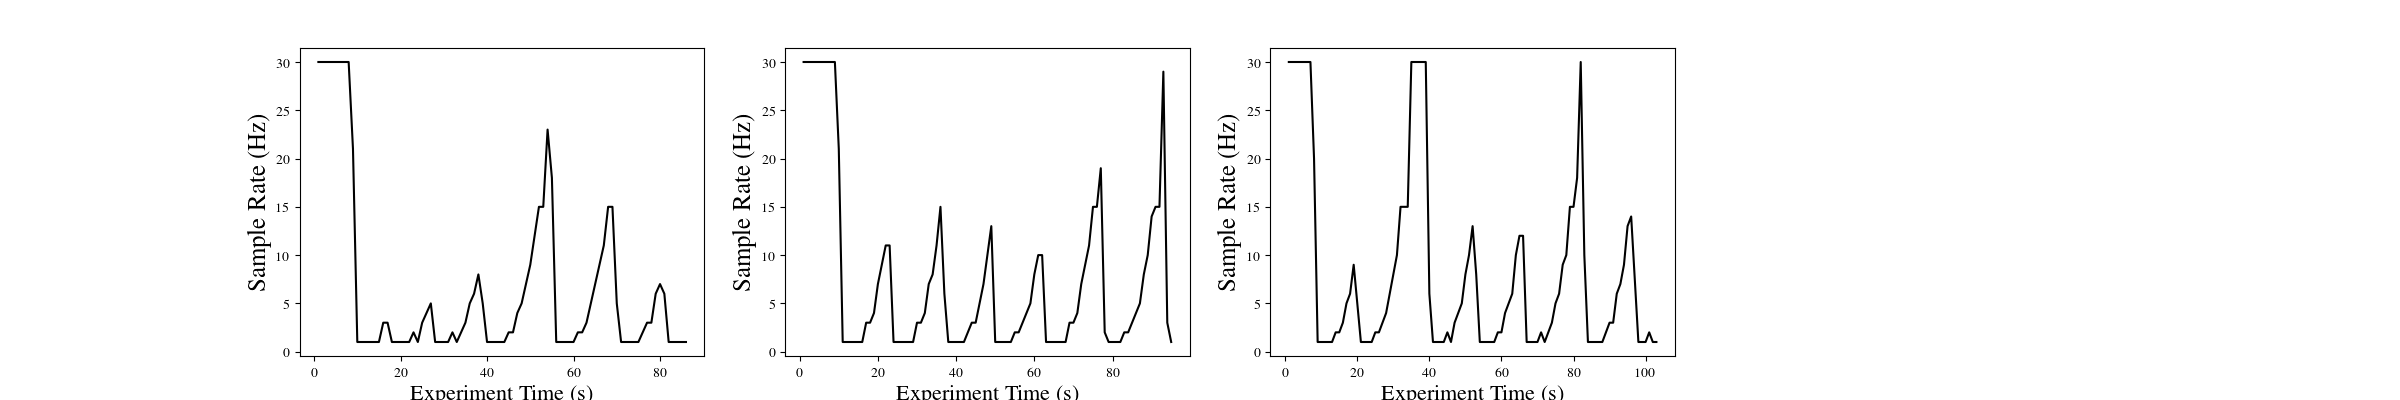

In [8]:
%matplotlib notebook
import collections

def plot_dy_sampling_freq(dy_exp_ss):
    sampled_idx = dy_exp_ss['index'].values
    sampled_idx = map(lambda x: int(x/30.0), sampled_idx)
    freq_counter = collections.Counter(sampled_idx)
    sorted_freqs = sorted(freq_counter.items(), key=lambda pair: pair[0])
    x, y = zip(*sorted_freqs)
    plt.plot(x[1:], y[1:], 'black')
    plt.xlabel('Experiment Time (s)',  fontsize=16)
    plt.ylabel('Sample Rate (Hz)', fontsize=18)

plt.figure(figsize=(24, 4))
for (h_idx, dy_exp_ss) in enumerate(dy_ss):
    plt.subplot(1, len(dy_ss)+1, h_idx+1)
    plot_dy_sampling_freq(dy_exp_ss)

In [ ]:
plt.savefig('fig-lego-example-sr.pdf', bbox_inches='tight')

### Impact of Dynamic Sampling Rate on Instruction Delay

When applying dynamic sampling rate, frames triggering instructions may no longer be sampled, causing delays in instructions. Below shows the delays (in # of frames) due to dynamic sampling

In [156]:
# some baseline frequency sampling savings and results
import copy
def print_stage_diff(stage_info, ref_stage_frame_idx):
    dataset_stage_frame_idx = np.array(stage_info)[:, :, 0].astype('int')
    stage_frame_diff = dataset_stage_frame_idx - ref_stage_frame_idx
    logger.debug('Difference in frames: {}'.format(stage_frame_diff))
    logger.debug('average: {}, std: {}'.format(np.mean(stage_frame_diff), np.std(stage_frame_diff)))

bsr = 30.0
srs = [15.0, 10.0]
for sr in srs:
    assert(bsr % sr == 0)
    period = int(bsr / sr)
    logger.info('sampling rate: {}, period: {}'.format(sr, period))
    sr_ss = copy.deepcopy([exp_ss[0::period] for exp_ss in ss])
    sr_ds_stage_info = []
    for sr_exp_ss in sr_ss:
        sr_ds_stage_info.append(detect_stage(LegoFSM(), sr_exp_ss))
    print_stage_diff(sr_ds_stage_info, dataset_stage_frame_idx)


[I 190523 11:24:28 <ipython-input-156-e7ec6c228f38>:14] sampling rate: 15.0, period: 2
[D 190523 11:24:29 <ipython-input-156-e7ec6c228f38>:6] Difference in frames: [[ 4  6  4  2  5  4  3]
     [ 4  5  3  5  6 21  8]
     [ 3  6 27  7  3  5 26]
     [ 5  4 10  4 21  9  4]]
[D 190523 11:24:29 <ipython-input-156-e7ec6c228f38>:7] average: 7.64285714286, std: 6.89313470944
[I 190523 11:24:29 <ipython-input-156-e7ec6c228f38>:14] sampling rate: 10.0, period: 3
[D 190523 11:24:29 <ipython-input-156-e7ec6c228f38>:6] Difference in frames: [[10  7  9 12 13  8 23]
     [10 10  8  9  7 23 18]
     [ 8 10 28  8 10  6 36]
     [ 9  9 12 15 30  9  9]]
[D 190523 11:24:29 <ipython-input-156-e7ec6c228f38>:7] average: 13.0714285714, std: 7.64352467045


# Ikea Duty Cycle

### Print Detected State Transitions on Dataset

In [25]:
import collections

from ikea.fsm import IkeaFSM
from rmexp import dataset_analysis as analysis

#Traces 1, 13, 14 dimension (200,300)
# Good Traces 1, 4, 7, 11, 12,  
trace_list = [1,4, 7, 11, 12]

ikea_resolution = collections.defaultdict(lambda: (168, 300))
ikea_resolution[1] = (200, 300)
ikea_resolution[13] = (200, 300)
ikea_resolution[14] = (200, 300)

dataset_stage_info = []
for trace_id in trace_list:
    im_h, im_w = ikea_resolution[trace_id]
    fsm = IkeaFSM(im_h=im_h, im_w=im_w)
    ss = analysis.get_ss_df('ikea', trace_id)
    inst = analysis.run_fsm_on_ss_for_inst(fsm, ss)
    detected_stages = inst[inst.notnull()].index.values
    print('============ikea-tr{} Detected State Transitions=========='.format(trace_id))
    print(detected_stages)
    dataset_stage_info.append(detected_stages)

============ikea-tr1 Detected State Transitions==========
[ 194  759 1207 2105 2757 3133 4014 4781]
============ikea-tr4 Detected State Transitions==========
[ 207  847 1126 2012 2784 3106 3773 4425]
============ikea-tr7 Detected State Transitions==========
[ 113 1079 1824 2607 3233 3697 4420 5570]
============ikea-tr11 Detected State Transitions==========
[ 196  985 1841 3031 4427 5021 5182 6700]
============ikea-tr12 Detected State Transitions==========
[ 273 1098 2411 3409 5020 6050 6451 7240]


### Ikea Duty Cycle Ground Truth

In [49]:
HANDLABELED_ACTIVE = {
        'ikea-tr1': [
            (184, 370),
            (670, 950),
            (1180, 1360),
            (2094, 2600),
            (2730, 2920),
            (3830, 3850),
            (4000, 4230),
            (4790, 5070),
        ],
        'ikea-tr3': [
            (180, 360),
            (980, 1190),
            (1460, 1610),
            (2450, 2890),
            (3180, 3250),
            (3900, 3960),
            (4200, 4440),
            (4700, 4980),
        ],
        'ikea-tr4': [
            (210, 360),
            (770, 980),
            (1140, 1320),
            (2000, 2270),
            (2800, 2880),
            (3656, 3700),
            (3790, 4060),
            (4440, 4650),
        ],
        'ikea-tr5': [
            (200, 350),
            (810, 1000),
            (1170, 1350),
            (1960, 2370),
            (2760, 2900),
            (3450, 3540),
            (3730, 4010),
            (4260, 4510),
        ], 
        'ikea-tr7': [
            (250, 600),
            (1076, 1130),
            (1820, 2130),
            (2600, 3060),
            (3230, 3500),
            (4200, 4340),
            (4880, 5200),
            (5700, 5960),
        ],  
        'ikea-tr11': [
            (260, 630),
            (1160, 1660),
            (1940, 2230),
            (3160, 4300),
            (4430, 4800),
            (5530, 5720),
            (6030, 6400),
            (6730, 6900),
        ], 
        'ikea-tr12': [
            (400, 730),
            (1460, 2200),
            (2480, 2800),
            (3400, 3760),
            (5000, 5330),
            (6090, 6200),
            (6560, 6900),
            (7290, 7500),
        ],    
        }

## Exploration of Ping-Pong Duty Cycle (Not Used in the Paper)

Uses "Cannot find Table" as a method to suppress 1s

In [7]:
sess = dbutils.get_session()

# get the first frame that state transition happened
exp_names = ['pingpong-tr{}'.format(idx) for idx in range(1, 6)]
ss = []
for exp_name in exp_names:
    exp_ss = [[int(item.idx), item.val] for item in sess.query(models.SS.val, 
                                           models.SS.name, 
                                           models.SS.index.label('idx')).filter(models.SS.name==exp_name).all()]
    ss.append(exp_ss)
sess.close()

state_no_table_msgs = [
    'Cannot find table',
    'Detected table too small',
    'Table top line too short',
    'Table top line tilted too much',
    "Table doesn't occupy bottom part of image",
    'Angle between two side edge not right',
    'Valid area too small after rotation'
]

def has_table(state):
    for msg in state_no_table_msgs:
        if msg in state:
            return False
    return True

In [37]:
def interval_extract(input_list): 
    """Extract continuous intervals out of a list of items"""
    length = len(input_list) 
    i = 0
    while (i< length): 
        low = input_list[i] 
        while i <length-1 and input_list[i]+1 == input_list[i + 1]: 
            i += 1
        high = input_list[i] 
        if (high - low >= 1): 
            yield [low, high] 
        elif (high - low == 1): 
            yield [low, ] 
            yield [high, ] 
        else: 
            yield [low, ] 
        i += 1

ds_long_no_table = [[], []]
long_no_table_thresh = 60
for (idx, exp_ss) in enumerate(ss):
    logger.info('========== pingpong-trace{} =============='.format(idx+1))
    no_table_idx = [item[0] for item in exp_ss if not has_table(item[1])]
    no_table_intervals = list(interval_extract(no_table_idx))
    long_no_table_intervals = zip(*[[item[0], item[1]-item[0]] for 
                               item in no_table_intervals if len(item) > 1 and item[1] - item[0] > long_no_table_thresh])
    logger.info(long_no_table_intervals)
    ds_long_no_table[0].append(long_no_table_intervals[0])
    ds_long_no_table[1].append(long_no_table_intervals[1])

[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:22] ========== pingpong-trace1 ==============
[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:27] [(56, 200), (82, 125)]
[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:22] ========== pingpong-trace2 ==============
[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:27] [(108, 961, 1342, 2398), (67, 91, 135, 170)]
[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:22] ========== pingpong-trace3 ==============
[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:27] [(344, 813, 1176), (112, 70, 61)]
[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:22] ========== pingpong-trace4 ==============
[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:27] [(771,), (88,)]
[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:22] ========== pingpong-trace5 ==============
[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:27] [(90, 1543), (111, 79)]


<IPython.core.display.Javascript object>


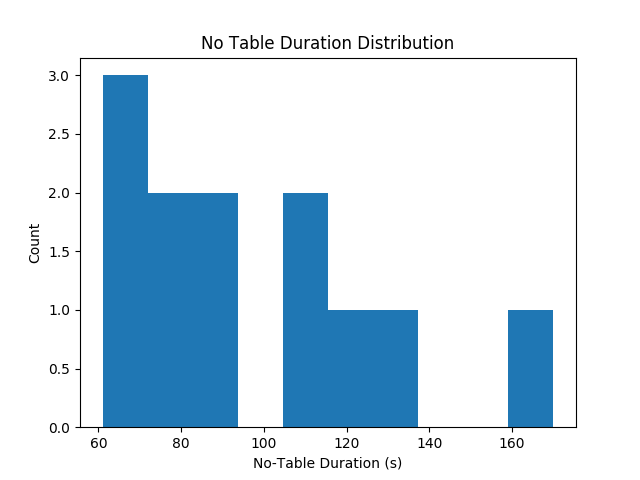

In [38]:
%matplotlib notebook
def plot_no_table_duration(data):
    data = data.flatten()
    plt.figure()
    plt.hist(data);
    plt.ylabel('Count');
    plt.xlabel('No-Table Duration (s)');
    plt.title('No Table Duration Distribution')

plot_no_table_duration(np.array([item for sublist in ds_long_no_table[1] for item in sublist]))

In [ ]:
# plot key frame and then use supression as a way
for (idx, exp_ss) in enumerate(ss):
    logger.info('========== pingpong-trace{} =============='.format(idx+1))